# Shor's Algorithm
First we will discuss the problem of period finding and use it to solve the problem of factoring integers.

In [1]:
# Initial Imports
import matplotlib.pyplot as plt
import numpy as np
from qiskit import QuantumCircuit, Aer, execute
from qiskit.visualization import plot_histogram
from math import gcd
from numpy.random import randint
import pandas as pd
from fractions import Fraction
print("Imports Successful")

Imports Successful


### An Example of Periodic Function in Shor's Algorithm

Could not find period, check a < N and have no common factors.


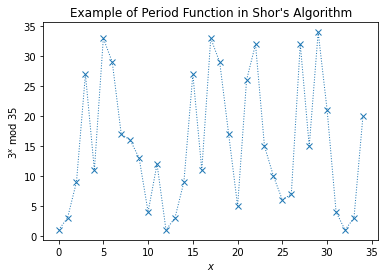

In [9]:
N = 35
a = 3

# calculate the plotting data
xvals = np.arange(N)
yvals = [np.mod(a**x, N) for x in xvals]

# displaying the graph
fig, ax = plt.subplots()
ax.plot(xvals,yvals,linewidth=1, linestyle='dotted', marker='x')
ax.set(xlabel='$x$', ylabel='$%i^x$ mod $%i$' % (a,N), 
       title="Example of Period Function in Shor's Algorithm")
try: # plot r on the graph
    r = yvals[1:].index(1) +1 
    plt.annotate(text='', xy=(0,1), xytext=(r,1), arrowprops=dict(arrowstyle='<->'))
    plt.annotate(text='$r=%i$' % r, xy=(r/3,1.5))
except:
    print('Could not find period, check a < N and have no common factors.')

## Qiskit Implementation
In this part, we will take the unitary operator U without discussing how it works actually. Lets take $a=7$ and $N=15$. The circuit for U is given below, where
$$
U|y\rangle = |ay\ \text{mod} 15\rangle
$$

In [11]:
def c_amod15(a, power):
    """Controlled multiplication by a mod 15"""
    if a not in [2,7,8,11,13]:
        raise ValueError("'a' must be 2, 7, 8, 11, 13")
    U = QuantumCircuit(4)
    for iteration in range(power):
        if a in [2,13]:
            U.swap(0,1)
            U.swap(1,2)
            U.swap(2,3)
        if a in [7,8]:
            U.swap(2,3)
            U.swap(1,2)
            U.swap(0,1)
        if a == 11:
            U.swap(1,3)
            U.swap(0,2)
        if a in [7, 11, 13]:
            for q in range(4):
                U.x(q)
    U = U.to_gate()
    U.name = "%i^%i mod 15" % (a, power)
    c_U = U.control()
    return c_U

In [12]:
def qft_dagger(n):
    """n-qubit QFTdagger the first n qubits in circ"""
    qc = QuantumCircuit(n)
    # Don't forget the Swaps!
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc.cu1(-np.pi/float(2**(j-m)), m, j)
        qc.h(j)
    qc.name = "QFT†"
    return qc

In [30]:
# Specifying Variables
a = 8
n_count = 8 # this is number of counting qubits

# Create the necessary Quantum Circuit
qc = QuantumCircuit(n_count + 4,n_count) # the four are for the eigenvector

# Initialise counting qubits with hadamard gates
for q in range(n_count):
    qc.h(q)
    
# and ancilla register in state |1>
#(This is not clear to me yet?????)
qc.x(3 + n_count)
qc.barrier()

# Do controlled-U operations
### This step is not properly understood
for q in range(n_count):
    qc.append(c_amod15(a, 2**q), 
             [q] + [i+n_count for i in range(4)])
    
# Inverse QFT
qc.append(qft_dagger(n_count),range(n_count))

#Measure
qc.measure(range(n_count),range(n_count))
qc.draw()
    

┌───┐ ░                                                             »
 q_0: ┤ H ├─░────────■────────────────────────────────────────────────────»
      ├───┤ ░        │                                                    »
 q_1: ┤ H ├─░────────┼──────────────■─────────────────────────────────────»
      ├───┤ ░        │              │                                     »
 q_2: ┤ H ├─░────────┼──────────────┼──────────────■──────────────────────»
      ├───┤ ░        │              │              │                      »
 q_3: ┤ H ├─░────────┼──────────────┼──────────────┼──────────────■───────»
      ├───┤ ░        │              │              │              │       »
 q_4: ┤ H ├─░────────┼──────────────┼──────────────┼──────────────┼───────»
      ├───┤ ░        │              │              │              │       »
 q_5: ┤ H ├─░────────┼──────────────┼──────────────┼──────────────┼───────»
      ├───┤ ░        │              │              │              │       »
 q_6: ┤ H ├─░────────┼──────────────┼──────────────┼──────────────┼───────»
      ├───┤ ░        │              │              │              │       »
 q_7: ┤ H ├─░────────┼──────────────┼──────────────┼──────────────┼───────»
      └───┘ ░ ┌─────┴┼──────┐┌─────┴┼──────┐┌─────┴┼──────┐┌─────┴┼──────┐»
 q_8: ──────░─┤0     │      ├┤0     │      ├┤0     │      ├┤0     │      ├»
            ░ │             ││             ││             ││             │»
 q_9: ──────░─┤1            ├┤1            ├┤1            ├┤1            ├»
            ░ │  8^1 mod 15 ││  8^2 mod 15 ││  8^4 mod 15 ││  8^8 mod 15 │»
q_10: ──────░─┤2            ├┤2            ├┤2            ├┤2            ├»
      ┌───┐ ░ │             ││             ││             ││             │»
q_11: ┤ X ├─░─┤3            ├┤3            ├┤3            ├┤3            ├»
      └───┘ ░ └─────────────┘└─────────────┘└─────────────┘└─────────────┘»
 c_0: ════════════════════════════════════════════════════════════════════»
                                                                          »
 c_1: ════════════════════════════════════════════════════════════════════»
                                                                          »
 c_2: ════════════════════════════════════════════════════════════════════»
                                                                          »
 c_3: ════════════════════════════════════════════════════════════════════»
                                                                          »
 c_4: ════════════════════════════════════════════════════════════════════»
                                                                          »
 c_5: ════════════════════════════════════════════════════════════════════»
                                                                          »
 c_6: ════════════════════════════════════════════════════════════════════»
                                                                          »
 c_7: ════════════════════════════════════════════════════════════════════»
                                                                          »
«                                                                       »
« q_0: ─────────────────────────────────────────────────────────────────»
«                                                                       »
« q_1: ─────────────────────────────────────────────────────────────────»
«                                                                       »
« q_2: ─────────────────────────────────────────────────────────────────»
«                                                                       »
« q_3: ─────────────────────────────────────────────────────────────────»
«                                                                       »
« q_4: ───────■─────────────────────────────────────────────────────────»
«             │                                                         »
« q_5: ───────┼───────────────■─────────────────────────────────────────»
« 

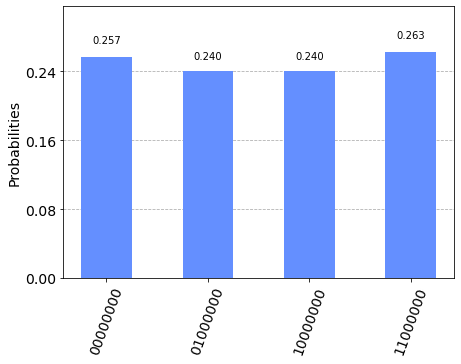

In [31]:
backend = Aer.get_backend('qasm_simulator')
results = execute(qc, backend, shots = 2048).result()
counts = results.get_counts()
plot_histogram(counts)

Now, we change these results to phases

In [32]:
rows, measured_phases = [], []
for output in counts:
    decimal = int(output, 2) # convert (base2) string into decimal
    phase = decimal/(2**n_count)
    measured_phases.append(phase)
    
    # Adding these values to rows in our table
    rows.append(["%s(bin) = %i(dec)" % (output, decimal),
               "%i/%i = %.2f" % (decimal, 2**n_count,phase)])
    
# printing the table
headers = ["Register output", "phase"]
df = pd.DataFrame(rows, columns=headers)
print(df)

            Register output           phase
0    00000000(bin) = 0(dec)    0/256 = 0.00
1   01000000(bin) = 64(dec)   64/256 = 0.25
2  10000000(bin) = 128(dec)  128/256 = 0.50
3  11000000(bin) = 192(dec)  192/256 = 0.75


In [33]:
# Now trying to find s and r
rows = []
for phase in measured_phases:
    frac = Fraction(phase).limit_denominator(15)
    rows.append([phase, "%i/%i" % (frac.numerator, frac.denominator), frac.denominator])
    
# printing table
headers = ["Phase", "Fraction", "Guess for r"]
df = pd.DataFrame(rows, columns = headers)
print(df)

   Phase Fraction  Guess for r
0   0.00      0/1            1
1   0.25      1/4            4
2   0.50      1/2            2
3   0.75      3/4            4


## Modular Exponentiation

In [35]:
def a2jmodN(a, j, N):
    """Compute a^{2^j} mod N  by repeated squaring"""
    for i in range(j):
        a = np.mod(a**2, N)
    return a

In [36]:
a2jmodN(7,,53)

44

## Factoring from Period Finding
### Example: Factoring 15

In [137]:
N = 15
np.random.seed(1) # This makes sure that we get reproducible result
a = randint(2,15)
print(a)

7


In [138]:
from math import gcd # Greatest common Divisor
gcd(a, N)

1

In [174]:
def qpe_amod15(a):
    n_count = 3
    qc = QuantumCircuit(4 + n_count, n_count)
    for q in range(n_count):
        qc.h(q)
    qc.x(3+n_count)
    for q in range(n_count):
        qc.append(c_amod15(a,2**q),
                 [q] + [i + n_count for i in range(4)])
    qc.append(qft_dagger(n_count), range(n_count))
    qc.measure(range(n_count), range(n_count))
    
    # simulating result
    backend = Aer.get_backend('qasm_simulator')
    
    # setting memory=True below allows us to see a list of each sequential result
    result = execute(qc,backend, shots=100, memory=True).result()
    readings = result.get_memory()
    print("Register Reading: " + readings[0])
    phase = int(readings[0],2)/(2**n_count)
    print("Corresponding Phase: %f" % phase)
    return phase    

In [175]:
np.random.seed(3) # this is to make sure we get reproducible result
phase = qpe_amod15(a) # phase = s/r
Fraction(phase).limit_denominator(15)

Register Reading: 110
Corresponding Phase: 0.750000


Fraction(3, 4)

In [176]:
frac = Fraction(phase).limit_denominator(15)
r = frac.denominator
print(r)

4


In [177]:
guesses = [gcd(a**(r//2)-1,N), gcd(a**(r//2)+1,N)]
print(guesses)

[3, 5]


In [287]:
a = 7
factor_found = False
attempt = 0
while not factor_found:        
    attempt += 1
    print("\nAttempt %i: " % attempt)
    phase = qpe_amod15(a)
    frac = Fraction(phase).limit_denominator(15)
    r = frac.denominator
    print("Result : r = %i" % r)
    if phase != 0:
        # Guesses
        guesses = [gcd(a**(r//2)-1, 15), gcd(a**(r//2)+1, 15)]
        print("Guessed Factor: %i and %i" % (guesses[0], guesses[1]))
        for guess in guesses:
            if guess != 1 and (15 % guess) == 0:
                print("*** Non-Trivial Factor Found: %i ***" % guess)
                factor_found = True


Attempt 1: 
Register Reading: 110
Corresponding Phase: 0.750000
Result : r = 4
Guessed Factor: 3 and 5
*** Non-Trivial Factor Found: 3 ***
*** Non-Trivial Factor Found: 5 ***
